In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


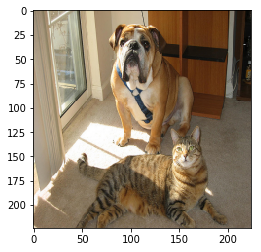

In [3]:
img = image.load_img('./example.png', target_size=(224, 224))
plt.imshow(img)
img = image.img_to_array(img)
img = img[np.newaxis,...]
img = preprocess_input(img)

In [4]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Define VGG model

In [5]:
vgg = VGG16(include_top=True, weights='imagenet')
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
for i, l in enumerate(vgg.layers):
    print(i, l)

0 <keras.engine.input_layer.InputLayer object at 0x7f49367a33c8>
1 <keras.layers.convolutional.Conv2D object at 0x7f49367901d0>
2 <keras.layers.convolutional.Conv2D object at 0x7f4936790b70>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f493677ae80>
4 <keras.layers.convolutional.Conv2D object at 0x7f4936730978>
5 <keras.layers.convolutional.Conv2D object at 0x7f4934700630>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f493471c978>
7 <keras.layers.convolutional.Conv2D object at 0x7f493471cef0>
8 <keras.layers.convolutional.Conv2D object at 0x7f49346d2278>
9 <keras.layers.convolutional.Conv2D object at 0x7f493466b0f0>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f4934688550>
11 <keras.layers.convolutional.Conv2D object at 0x7f49346a1080>
12 <keras.layers.convolutional.Conv2D object at 0x7f4934642320>
13 <keras.layers.convolutional.Conv2D object at 0x7f493465d128>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f4934613198>
15 <keras.layers.convolutional.Conv2D object at 

In [7]:
vgg.get_layer(index=17).name

'block5_conv3'

# Prediction

In [8]:
result = vgg.predict(img)
top_n = 5
top = decode_predictions(result, top=top_n)[0]
classes = np.argsort(result[0])[-top_n:][::-1]

In [9]:
top

[('n02108089', 'boxer', 0.42014128),
 ('n02108422', 'bull_mastiff', 0.28162226),
 ('n02123159', 'tiger_cat', 0.05345008),
 ('n02129604', 'tiger', 0.050134618),
 ('n02109047', 'Great_Dane', 0.049807888)]

In [10]:
classes

array([242, 243, 282, 292, 246])

In [11]:
print('Model prediction:')
for c, p in zip(classes, top):
    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))

Model prediction:
	boxer          	(242)	with probability 0.420
	bull_mastiff   	(243)	with probability 0.282
	tiger_cat      	(282)	with probability 0.053
	tiger          	(292)	with probability 0.050
	Great_Dane     	(246)	with probability 0.050


In [12]:
class_name = decode_predictions(np.eye(1, 1000, np.argmax(result)))[0][0][1]
class_name

'boxer'

# Grad-CAM

In [13]:
y_cls = vgg.output[0, np.argmax(result)]
conv_output = vgg.get_layer(index=17).output
grads = K.gradients(y_cls, conv_output)[0]
grads_function = K.function([vgg.input], [conv_output, grads])

output, grad_val = grads_function([img])
output, grad_val = np.squeeze(output), np.squeeze(grad_val)
print(output.shape, grad_val.shape)

(14, 14, 512) (14, 14, 512)


In [15]:
y_cls

<tf.Tensor 'strided_slice:0' shape=() dtype=float32>

(14, 14)
0.0013003487 0.014981687 0.0020186189 -0.0057199183
0.0013003487 0.014981687 0.0020186189 0.0
(224, 224)


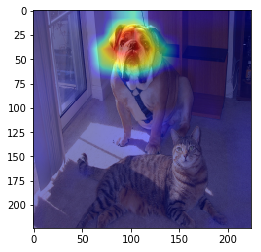

In [23]:
weights = np.mean(grad_val, axis=(0, 1))
cam = np.dot(output, weights)
cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)
print(cam[0,0], cam[0,100], cam[100,0], cam[100,100])
cam = np.maximum(cam, 0)
print(cam[0,0], cam[0,100], cam[100,0], cam[100,100])
print(cam.shape)
cam = cam / cam.max()
plt.subplot(111)
plt.imshow(image.load_img('./example.png', target_size=(224, 224)))
plt.imshow(cam, cmap='jet', alpha=.5)
plt.show()

# Guided Backpropagation